In [103]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that Keras should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras
import pydub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils.waves import gen_sine

In [54]:
from keras import Sequential
from keras.layers import Dense

In [55]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")


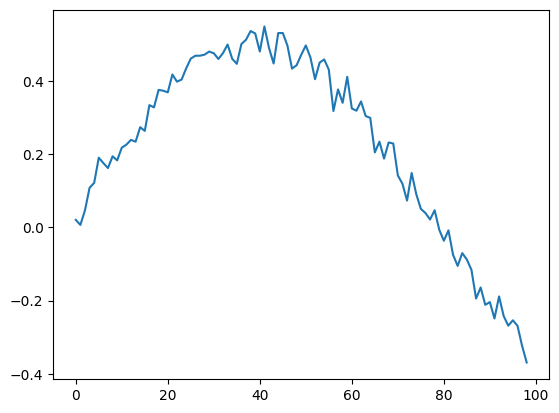

In [56]:


secs = 5
sr = 48000
freq = 300
testing_np_version = gen_sine(freq, sr, secs, noise_sd=0.03)
plt.plot(testing_np_version[1:100, 0])
plt.show()

In [57]:
write("mp3_check.mp3", sr, testing_np_version,normalized=True)

In [77]:
n = 5

In [58]:
# Randomly generate frequencies between C2 and C8
c2 = 65.41 # n = 16
c8 = 4186.01 # n = 88
c7 = 2093.00 # n = 76

# Generate N training samples
N = 100000
freqs = np.random.uniform(c2, c8, size=N)
noise_sds = np.random.exponential(0.02, size=N)
amplitudes = np.random.uniform(0.4, 1, size=N)
x_intercepts = np.random.uniform(0, 2*np.pi, size=N)
X_lst = []
for i in range(N):
    sine = gen_sine(freqs[i], sr=48000, secs=1/64, noise_sd=noise_sds[i], amplitude=amplitudes[i], x_intercept=x_intercepts[i])[:, 0]
    X_lst.append(sine)

X = np.stack(X_lst)
y = freqs
split = 0.7
X_train = X[:int(split*len(X_lst))]
y_train = freqs[:int(split*len(X_lst))]
X_test = X[int(split*len(X_lst)):]
y_test = freqs[int(split*len(X_lst)):]
X_train.shape

(70000, 750)

In [131]:
def train_nn(model, X, y, epochs=100):
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X, y, validation_split=0.2, batch_size=int(len(X)*0.1), epochs=epochs, callbacks=[callback])
    return history, model

def generate_frequency(key_num):
    return np.round(np.power(2, (key_num-49)/12) * 440, 2)

def eval_nn(model, max_freq=None):
    freqs = [generate_frequency(n) for n in range(16, 89)] # actual note frequencies
    if max_freq is not None:
        freqs = [y for y in freqs if y < max_freq]
    X_test = []
    y_test = []
    noise_sd = np.random.exponential(0.02)
    x_intercept = np.random.uniform(0, 2*np.pi)
    amplitudes = np.arange(0, 1, 0.05).round(2)
    for i, freq in enumerate(freqs):
        for amplitude in amplitudes:
            sine = gen_sine(freq, sr=48000, secs=1/64, noise_sd=noise_sds[i], amplitude=amplitude, x_intercept=x_intercepts[i])[:, 0]
            X_test.append(sine)
            y_test.append(freq)
    X_test = np.stack(X_test) # sine waves generated with actual note frequencies
    y_pred = [pred[0] for pred in model.predict(X_test)]
    # plot grid of losses
    plot_heatmap(np.array(y_test), np.array(y_pred), np.tile(amplitudes, len(freqs)))

def plot_heatmap(true_frequencies, predicted_values, amplitudes):
    """
    Plot a heatmap for true frequencies, predicted values, and amplitudes.

    Parameters:
    - true_frequencies: List of true frequencies
    - predicted_values: List of predicted values
    - amplitudes: List of amplitudes corresponding to each pair

    Returns:
    - None
    """
    absolute_difference = np.abs(np.array(predicted_values) - np.array(true_frequencies))
    percentage_difference = absolute_difference / np.array(true_frequencies) * 100

    data = {'True Frequency': true_frequencies,
            'Amplitude': amplitudes,
            'Percentage Difference': percentage_difference}

    df = pd.DataFrame(data)

    # Create a pivot table for the heatmap
    pivot_table = df.pivot_table(values='Percentage Difference', index='Amplitude', columns='True Frequency', aggfunc='mean')

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Percentage Difference'})
    plt.title('Heatmap of Percentage Difference for True Frequencies and Amplitudes')
    plt.show()


In [75]:
# Build network
input_shape = len(X_lst[0])
 # create model
model = keras.Sequential()
model.add(Dense(input_shape, input_shape=(input_shape,), kernel_initializer='normal', activation='relu'))
model.add(Dense(input_shape, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Display a summary of the model architecture.
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 750)               563250    
                                                                 
 dense_25 (Dense)            (None, 750)               563250    
                                                                 
 dense_26 (Dense)            (None, 1)                 751       
                                                                 
Total params: 1,127,251
Trainable params: 1,127,251
Non-trainable params: 0
_________________________________________________________________


In [76]:
history, model = train_nn(model, X, y, epochs=3*750)

Epoch 1/2250
8/8 [==============================] - 2s 164ms/step - loss: 5870438.5000 - val_loss: 5732079.5000
Epoch 2/2250
8/8 [==============================] - 1s 145ms/step - loss: 5644654.5000 - val_loss: 5400380.5000
Epoch 3/2250
8/8 [==============================] - 1s 147ms/step - loss: 5199093.5000 - val_loss: 4792548.5000
Epoch 4/2250
8/8 [==============================] - 1s 156ms/step - loss: 4433891.5000 - val_loss: 3829098.5000
Epoch 5/2250
8/8 [==============================] - 1s 149ms/step - loss: 3315901.7500 - val_loss: 2541951.0000
Epoch 6/2250
8/8 [==============================] - 1s 153ms/step - loss: 1967430.6250 - val_loss: 1225203.7500
Epoch 7/2250
8/8 [==============================] - 1s 148ms/step - loss: 832211.5000 - val_loss: 454657.6875
Epoch 8/2250
8/8 [==============================] - 1s 147ms/step - loss: 408167.5625 - val_loss: 412975.3750
Epoch 9/2250
8/8 [==============================] - 1s 149ms/step - loss: 425356.7812 - val_loss: 394056.437

30/30 [==============================] - 0s 1ms/step
True frequency: 65.41; predicted: 987.4002075195312
True frequency: 65.41; predicted: 883.8875732421875
True frequency: 65.41; predicted: 783.9739990234375
True frequency: 65.41; predicted: 634.61669921875
True frequency: 65.41; predicted: 556.280029296875
True frequency: 65.41; predicted: 458.2691955566406
True frequency: 65.41; predicted: 372.621337890625
True frequency: 65.41; predicted: 313.4034729003906
True frequency: 65.41; predicted: 210.16004943847656
True frequency: 65.41; predicted: 156.7084503173828
True frequency: 65.41; predicted: 117.1258316040039
True frequency: 65.41; predicted: 105.95367431640625
True frequency: 65.41; predicted: 81.56857299804688
True frequency: 65.41; predicted: 72.15421295166016
True frequency: 65.41; predicted: 89.8056869506836
True frequency: 65.41; predicted: 60.228084564208984
True frequency: 65.41; predicted: 44.608642578125
True frequency: 65.41; predicted: 81.91989135742188
True frequency:

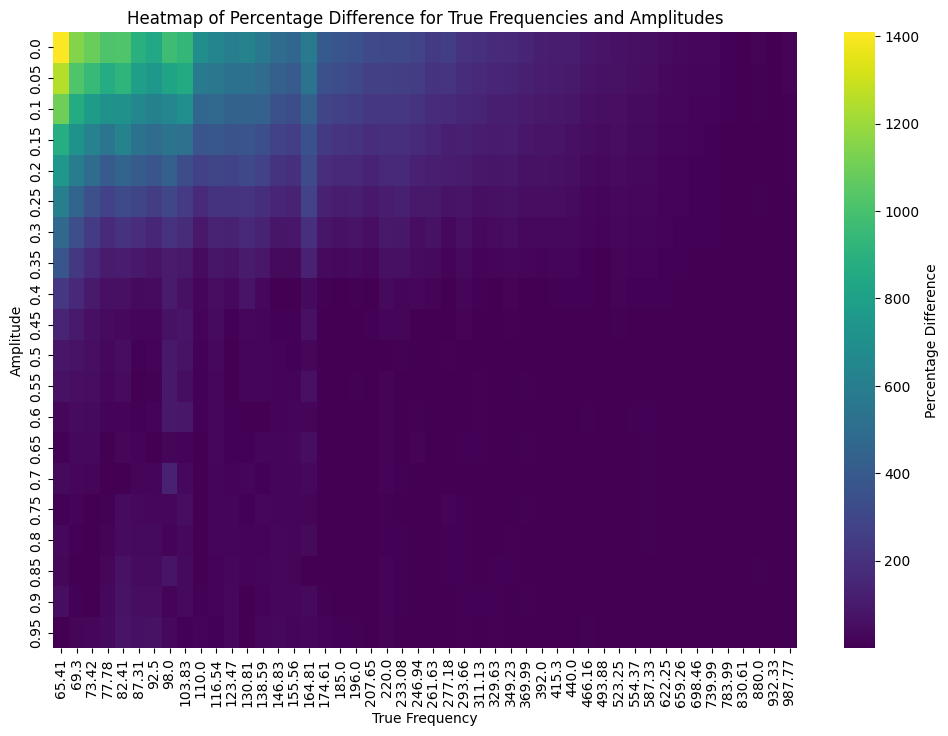

In [132]:
eval_nn(model, max_freq=1000)

In [ ]:
model.predict(np.stack([gen_sine(91.25, sr=48000, secs=1/64, noise_sd=, amplitude=amplitude, x_intercept=x_intercepts[i])[:, 0]]))

In [143]:
model.save("../models/note_detect.h5", save_format="h5")

In [22]:
from tensorflow.keras.models import load_model
model_eval = load_model('../models/note_detect.h5', compile=False)

In [23]:
model_eval.predict(np.expand_dims(testing_np_version[:, 0], 0))

1/1 [==============================] - 0s 32ms/step


array([[630.546]], dtype=float32)

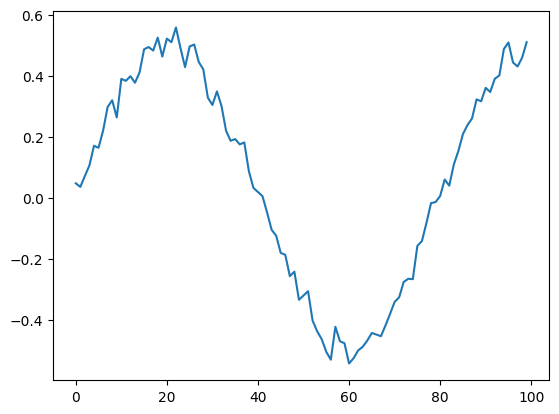

In [24]:
plt.plot(testing_np_version[:100, 0])